In [3]:
# libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectKBest, SelectFromModel
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from utils import create_dataset_mri, cv, create_dataset_eeg


#CDE
#from cde.density_estimator import MixtureDensityNetwork
from tensorflow.python.keras.activations import tanh

#TF
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# load the data
behavioral = pd.read_csv("data/Behavioral/AllData.csv")

# general info
shape = behavioral.shape  #2096, 7042
print(shape)

(2096, 7042)


In [7]:
list(filter(lambda x: "SWAN" in x, behavioral.columns))

['SWAN_01',
 'SWAN_02',
 'SWAN_03',
 'SWAN_04',
 'SWAN_05',
 'SWAN_06',
 'SWAN_07',
 'SWAN_08',
 'SWAN_09',
 'SWAN_10',
 'SWAN_11',
 'SWAN_12',
 'SWAN_13',
 'SWAN_14',
 'SWAN_15',
 'SWAN_16',
 'SWAN_17',
 'SWAN_18',
 'SWAN_IN_Avg',
 'SWAN_HY_Avg',
 'SWAN_Avg']

# Consider the dataset with all patients

(1306, 62)
(749, 62)


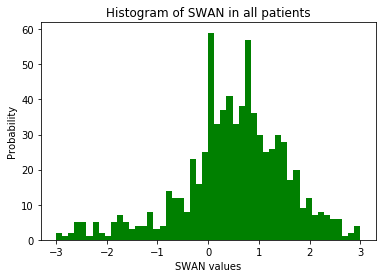

0.4992580431682243
1.0994153124778594


In [9]:
target = 'SWAN_Avg'
disease = None
#disease = 'Attention-Deficit/Hyperactivity Disorder'
category = None
#category = 'DX_01_Sub' #Irrelevant since we are dropping the columns after

# Create the dataset dropping the diagnosis columns since we are not interested in them
data = create_dataset_eeg(spectro= True, disease = disease, category = category, SCORE = target)
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass


# Drop the rows with some NaNs

print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]


# Plot distribution of the target variable
plt.hist(data[target], 50, density=False, facecolor='g')
plt.xlabel('SWAN values')
plt.ylabel('Probability')
plt.title('Histogram of SWAN in all patients')
plt.show()

print(np.mean(data[target]))
print(np.var(data[target]))

In [11]:
# Define the labels and the features for regression
y = data[target]
X = data.drop([target, 'id'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Store the dimensionality of the input
input_dim = X.shape[1]

## Define baseline

In [12]:
# Baseline: predict always the average
pred = np.full_like(np.zeros(len(y)), fill_value=np.mean(y))
mse = sum((pred - y)**2)/len(y)
print('Prediction mean: {}'.format(np.mean(y)))
print('MSE mean: {}'.format(mse))
r2 = r2_score(y_pred=(pred), y_true=y)
print('R2 mean: {}'.format(r2))

pred = np.full_like(np.zeros(len(y)), fill_value=np.median(y))
mse = sum((pred - y)**2)/len(y)
print('\nPrediction median: {}'.format(np.median(y)))
print('MSE median: {}'.format(mse))
r2 = r2_score(y_pred=pred, y_true=y)
print('R2 median: {}'.format(r2))

Prediction mean: 0.4992580431682243
MSE mean: 1.09941531247786
R2 mean: 0.0

Prediction median: 0.555555
MSE median: 1.1025846598263782
R2 median: -0.0028827571460467993


**Note:** the r^2 is defined as 1 minus the ratio between the MSE of the model and the MSE of the sample mean, so it does not give us any additional info but it makes the comparison with the baseline more immediate.

### Simple Linear Regression

In [13]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 1.2274195655143005
R squared: -0.12098394278992775


### Linear Regression + Tree-based feature selection

In [14]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 1.1286364048824478
R squared: -0.03954319225429813


### SVR + Tree-based feature selection

In [15]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('regression', SVR())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 1.152629306830803
R squared: -0.06028380653739053


### Random Forest

In [16]:
search_space = [1,5,10,30,60,100,200]
mses_to_plot = []
for n_trees in search_space:

    pipe = Pipeline([ ('scaling', StandardScaler()),
      ('rf', RandomForestRegressor(n_estimators=n_trees, n_jobs=4))
    ])
    (mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

    mse = np.mean(mses)
    mses_to_plot.append(mse)
    print('MSE: {}'.format(mse))
    r2 = np.mean(r2s)
    print('R squared: {}'.format(r2))

MSE: 2.363128704298073
R squared: -1.2031925254859843
MSE: 1.4302053704672124
R squared: -0.37708676256715024
MSE: 1.2532849920057805
R squared: -0.14375570575085841
MSE: 1.1673180594391042
R squared: -0.07402709867280705
MSE: 1.2208446189865496
R squared: -0.12271751927707975
MSE: 1.1917596183308672
R squared: -0.1020557612487263
MSE: 1.1760173236169136
R squared: -0.07445406776390759


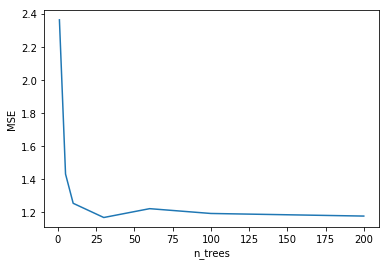

In [17]:
# Show relationship between size of the forest and error
plt.plot(search_space, mses_to_plot)
plt.ylabel('MSE')
plt.xlabel('n_trees')
plt.show()

### Neural Net

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(input_dim,)),
  tf.keras.layers.Dense(64, activation='tanh'),
  tf.keras.layers.Dense(64, activation='tanh'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
def cv_for_nn(model, data, labels, n_splits = 5):
    '''
    model: must be a sklearn object with .fit and .predict methods
    data: the X matrix containing the features, can be a pd.DataFrame or a np object (array or matrix)
    labels: y, can be a pd.DataFrame or a np array
    n_splits: number of desired folds
    => returns array of mean suqared error calculated on each fold
    '''
    kf = KFold(n_splits=n_splits, shuffle=True)
    data = np.array(data).astype('float32')
    labels = np.array(labels).astype('float32')
    mses = []
    i = 1
    for train, test in kf.split(data):
        print("Split: {}".format(i), end="\r")
        X_train, X_test, y_train, y_test = data[train], data[test], labels[train], labels[test]
        
        reset_weights(model)
        
        model.fit(x=X_train, y=y_train, verbose=0, epochs=1000)
        mse = model.evaluate(x=X_test,  y=y_test, verbose=1)[0]
        
        pred = model.predict(x=X_test)
        
        mse2 = sum((pred.flatten()-y_test)**2)/len(y_test)
        
        print('MSE: {}'.format(mse))
        mses.append(mse)
        i = i+1
    return mses

res = cv_for_nn(model=model, data=X_scaled, labels=y, n_splits=5)
np.mean(res)

150/150 [==============================] - 0s 167us/sample - loss: 1.6231 - acc: 0.0267
MSE: 1.6231479851404826
150/150 [==============================] - 0s 25us/sample - loss: 1.7058 - acc: 0.0200
MSE: 1.7058124860127768
150/150 [==============================] - 0s 25us/sample - loss: 1.8537 - acc: 0.0333
MSE: 1.853744894663493
150/150 [==============================] - 0s 29us/sample - loss: 1.9107 - acc: 0.0533
MSE: 1.9106853969891866
149/149 [==============================] - 0s 29us/sample - loss: 2.1050 - acc: 0.0067
MSE: 2.105041448701948


1.8396864423015775

### Conclusions
There seems to be almost no relationship between the EEG data and the results to the SWAN test, if all patients are considered regardless the diagnosis.

# Consider only patients with ADHD

(578, 62)
(339, 62)


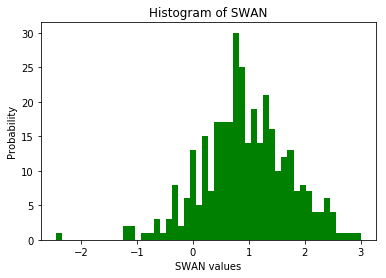

0.9401831681415929
0.6049926935949305


In [21]:
target = 'SWAN_Avg'
#disease = None
disease = 'Attention-Deficit/Hyperactivity Disorder'
#category = None
category = 'DX_01_Sub' #Irrelevant since we are dropping the columns after

# Create the dataset dropping the diagnosis columns since we are not interested in them
data = create_dataset_eeg(disease = disease, category = category, SCORE = target)
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass


# Drop the rows with some NaNs

print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]


plt.hist(data[target], 50, density=False, facecolor='g')
plt.xlabel('SWAN values')
plt.ylabel('Probability')
plt.title('Histogram of SWAN')
plt.show()


print(np.mean(data[target]))
print(np.var(data[target]))

In [23]:
# Define the labels and the features for regression
y = data[target]
X = data.drop([target, 'id'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Store the dimensionality of the input
input_dim = X.shape[1]

## Define baseline

In [24]:
# Baseline: predict always the average
pred = np.full_like(np.zeros(len(y)), fill_value=np.mean(y))
mse = sum((pred - y)**2)/len(y)
print('Prediction mean: {}'.format(np.mean(y)))
print('MSE mean: {}'.format(mse))
r2 = r2_score(y_pred=(pred), y_true=y)
print('R2 mean: {}'.format(r2))

pred = np.full_like(np.zeros(len(y)), fill_value=np.median(y))
mse = sum((pred - y)**2)/len(y)
print('\nPrediction median: {}'.format(np.median(y)))
print('MSE median: {}'.format(mse))
r2 = r2_score(y_pred=pred, y_true=y)
print('R2 median: {}'.format(r2))

Prediction mean: 0.9401831681415929
MSE mean: 0.6049926935949299
R2 mean: 0.0

Prediction median: 0.8888879999999999
MSE median: 0.6076238878696051
R2 median: -0.0043491339689401


**Note:** the r^2 is defined as 1 minus the ratio between the MSE of the model and the MSE of the sample mean, so it does not give us any additional info but it makes the comparison with the baseline more immediate.

### Simple Linear Regression

In [25]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 0.8431456647575176
R squared: -0.4569005529725205


### Linear Regression + Tree-based feature selection

In [26]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 0.7013898325068404
R squared: -0.1865737247386006


### SVR + Tree-based feature selection

In [27]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('regression', SVR())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 0.6787011695244547
R squared: -0.14755398082849697


### Random Forest

In [28]:
search_space = [1,5,10,30,60,100,200]
mses_to_plot = []
for n_trees in search_space:

    pipe = Pipeline([ ('scaling', StandardScaler()),
      ('rf', RandomForestRegressor(n_estimators=n_trees, n_jobs=4))
    ])
    (mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

    mse = np.mean(mses)
    mses_to_plot.append(mse)
    print('MSE: {}'.format(mse))
    r2 = np.mean(r2s)
    print('R squared: {}'.format(r2))

MSE: 1.4697949126876537
R squared: -1.5193043136009214
MSE: 0.8094330323411583
R squared: -0.3794981235752497
MSE: 0.6792462525919709
R squared: -0.15915260009140564
MSE: 0.6410291629628205
R squared: -0.061093029803808985
MSE: 0.6657764736274501
R squared: -0.14928343515913323
MSE: 0.644228619009497
R squared: -0.09160440279601684
MSE: 0.6512383608776998
R squared: -0.08630896912054574


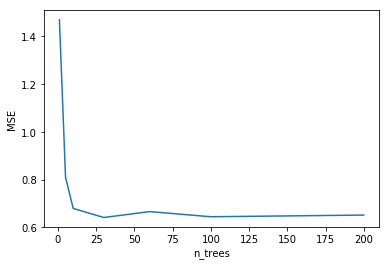

In [29]:
# Show relationship between size of the forest and error
plt.plot(search_space, mses_to_plot)
plt.ylabel('MSE')
plt.xlabel('n_trees')
plt.show()

### Conclusions
Even if we consider the subset of patients who were diagnosed ADHD, there still seems to be almost no relationship between the MRI data and the results to the SWAN test.